# Final Project - Music Classifier

Jake Murray

This project is a song genre classifier, where given a song (.mp3 file), it will analyze the song and provide its genre with a margin of confidence.

The dataset contains 249 unique songs, 5 genres with 50 songs each. The genres were:
   - Rap
   - Pop
   - Country
   - Rock
   - Jazz (only 49 songs due to an error with files)
   
I selected these genres because of their abilitied to have unique aspects in their own right while also having a sectrum of possibility.  Fusions like   Pop-Country, Hip-Hop/Rap, and Rock-Country will be an interesting challege for the model, while also having to learn that bands like Metallica, The Beatles, and U2 all have a very unique sound while still all technically falling under the Rock genre.

In [2]:
# imports libraries needed for converting the mp3 files to the images slices 
from subprocess import Popen, PIPE, STDOUT
from PIL import Image

import sys
import os
import eyed3

In [3]:
# Constant variables needed for some calculations
size = 128
pixelPerSecond = 50

# All paths where files are loaded from and/or saved
currentPath = os.path.abspath('')
rawDataPath = "Data/Raw/"
slicesPath = "Data/Slices/"
datasetPath = "Data/Dataset/"
spectrogramsPath = "Data/Spectrograms/"
tmpPath = "Data/tmp/"

eyed3.log.setLevel("ERROR")

In [4]:
# establish the genres present in the data, 
# will automatically adjust for the inplementation of new songs
genres = os.listdir(slicesPath)
genres = [filename for filename in genres if os.path.isdir(slicesPath+filename)]
nbClasses = len(genres)

print(genres)

["'Country'", "'Jazz'", "'Pop'", "'Rap'", "'Rock'"]


# Establishing Data and Building the Model

Now that the .mp3 files are in a usable format (from the other Jupyter Notebook file) for convolutional analysis, we can define these files more easily into useful datasets.  Using arrays and one hot encoding, we can create both training and testing datasets, with a split of 200 train - 50 test.

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os
import cv2
import random

from sklearn.feature_extraction import image
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

Using TensorFlow backend.


# Slices

Below is an example of a "slice," or one part of the song that is being analyzed.  It comes out as a 128x128 image, which is easily reduced down to a 32x32 image for analysis.  Every song ranges from 60 to 150 slices depending on the length, which "artifically" increases the amount of training/testing data.

The desired result is in the name of the file, which is easy acquired and helps identify which slices go together

'Country'


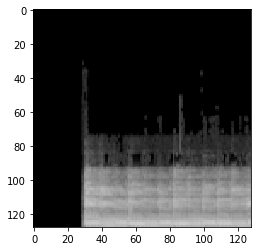

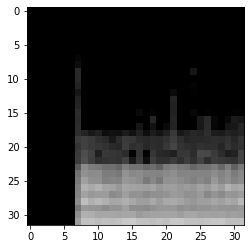

In [6]:
def showImage(file_path):
    for genre in genres:
        print(genre)
        #to look through each genre folder present in the directory
        path = os.path.join(file_path, genre)
        for image in os.listdir(path):
            image_array = cv2.imread(os.path.join(path, image))
            plt.imshow(image_array, cmap = "gray")
            plt.show()
            break
        break
    return image_array

def resize(images):
    new_image_array = cv2.resize(images, (32, 32))
    plt.imshow(new_image_array, cmap = "gray")
    plt.show()

slice_img = showImage(slicesPath)
resize(slice_img)

# Getting a Dataset

Now that we have all of the images defined thoroughly, we can use some functions to help get these images into python for analysis and application in the model.  These are taken from assignment 5/7 when we did convolutional networks, and is an easy way to pull images from a file on my machine.  This is also a consistent way to provide future analysis and the method below using the os library is used throughout this project.

This method of getting files from the computer was shown to me by Nick Woida, in the video linked below:

https://www.youtube.com/watch?v=j-3vuBynnOE&list=LLKC9FMZ-cz7yAiF33Evw3NQ&index=3&t=9s

In [7]:
#takes all local slices and and will add them to the "dataset" list
def createDataset(file_path, size):
    data = []
    for genre in genres:
        i = 0
        path = os.path.join(file_path, genre)
        genre_id = genres.index(genre)
        
        for image in os.listdir(path):
            try:
                if (i < size):
                    image_array = cv2.imread(os.path.join(path, image))
                    new_image = cv2.resize(image_array, (32, 32))
                    data.append([new_image, genre_id])
                    i += 1
                else:
                    break
            except Exception as e:
                pass
    print("Dataset Created!")
    return data

dataset = createDataset(slicesPath, 20000) # the value 20000 here is simply used to make sure all slices are used for each genre

Dataset Created!


### Establish more refined Datasets

Once we have an overall dataset from above, we can break this down further with train_test_split, in order to have more access to data and to better analyze/test everything.  There is a 80-20 split for training and testing data.  The Y data is using one hot encoding, and the X data value is normalized as well.

In [8]:
x = []
y = []

for feature, label in dataset:
    x.append(feature)
    y.append(label)
    
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state = 0)

x_train = np.array(x_train).reshape(-1, 32, 32, 3)
x_test = np.array(x_test).reshape(-1, 32, 32, 3)
x_test = x_test / 255

y_train_one = to_categorical(y_train)
y_test_one = to_categorical(y_test)

print("x_train shape: ", x_train.shape)
print("x_test shape: ", x_test.shape)

x_train shape:  (18992, 32, 32, 3)
x_test shape:  (4748, 32, 32, 3)


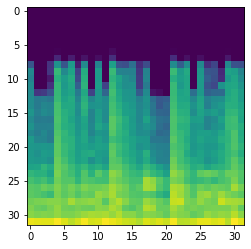

In [9]:
#example of a refined slice after out adjustment
plt.imshow(x_train[4000,:,:,2])
plt.show()

# Defining and Creating the Model

This is a convolution model almost exaclty the same as the ones we have used on assignment 5/7 in class.

Dropout is set to 20% after each set of convolution, with 2x2 maxpooling as well.  Using a basic relu activation throughout with softmax at the end

In [10]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu', input_shape=(32, 32, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu'))

model.add(Flatten(data_format = None))
model.add(Dropout(0.2))

model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(512, activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(5, activation='softmax'))

model.summary(0)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
dropout_2 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 64)        36928     
__________

### Adadelta Optimizer

I opted to use the Adadelta optimizer initally to just test different types of optimization.  Adadelta optimizer looks at changing the learning rate through a moving window of updates, rather than by looking at past gradients like other optimizers.

Here is a link for more info on adadelta:
https://keras.io/optimizers/

In [11]:
model.compile(loss='categorical_crossentropy', optimizer='adadelta', metrics=['accuracy'])

In [12]:
history = model.fit(x_train, y_train_one, batch_size=256, epochs=20, validation_split=0.2)

Train on 15193 samples, validate on 3799 samples
Epoch 1/20
15193/15193 [==============================] - 77s 5ms/step - loss: 1.8462 - acc: 0.2561 - val_loss: 1.5869 - val_acc: 0.2640
Epoch 2/20
15193/15193 [==============================] - 72s 5ms/step - loss: 1.5825 - acc: 0.2768 - val_loss: 1.5703 - val_acc: 0.3056
Epoch 3/20
15193/15193 [==============================] - 66s 4ms/step - loss: 1.5593 - acc: 0.2841 - val_loss: 1.5321 - val_acc: 0.2795
Epoch 4/20
15193/15193 [==============================] - 65s 4ms/step - loss: 1.4685 - acc: 0.3552 - val_loss: 1.4498 - val_acc: 0.3651
Epoch 5/20
15193/15193 [==============================] - 68s 4ms/step - loss: 1.4020 - acc: 0.4048 - val_loss: 1.3426 - val_acc: 0.4004
Epoch 6/20
15193/15193 [==============================] - 59s 4ms/step - loss: 1.2799 - acc: 0.4761 - val_loss: 1.1168 - val_acc: 0.5754
Epoch 7/20
15193/15193 [==============================] - 59s 4ms/step - loss: 1.1674 - acc: 0.5310 - val_loss: 1.2041 - val_acc:

In [14]:
model.evaluate(x_test, y_test_one)[1]

4748/4748 [==============================] - 5s 1ms/step


0.23441449033681747

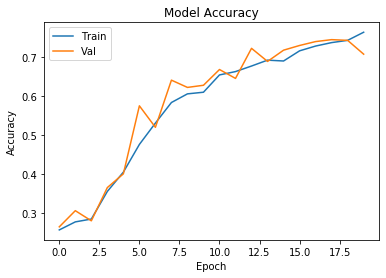

In [15]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

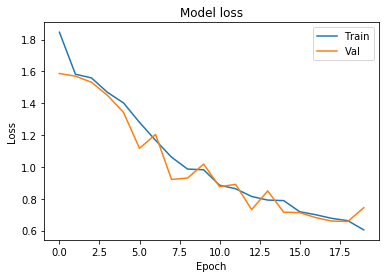

In [16]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

# Results

The results above are nice to look at and provide the accuracy per slice, which is definitely useful information.  This alone however does not cover all of the results we want to look at.  Many slices are all being applied to the same song, and we would like to see how they compare to eachother, and what the majority decision is to get a guess for the song as a whole.  So in the code below, we are going to look at the results for each input/output from the model to analyze the majority consensus.

In [ ]:
from keras import backend as K

get_out = K.function([model.layers[0].input], [model.layers[17].output])
output = get_out([x])[0]

## What the output means

The output of this model provides 5 values, each of the values will show the confidence of the slice being that specific genre. 
Knowing this, we can find the results of how confident the model is identifying songs in their entirity. A high output for an entry means it is very confident, and the lower it gets the lower its confidence. This is also where the evaluation scores for the slices come from in the model.  It takes the highest value as its result for that slice, regardless of if it is only 3 points higher or 60 points higher.

In [ ]:
#this cell is used to get the count of how many slices there are per genre.  This will be useful later
rockCount = 0
jazzCount = 0
popCount = 0
rapCount = 0
countryCount = 0

for obj in output:
    if max(obj) == obj[0]:
        countryCount += 1
    elif max(obj) == obj[1]:
        jazzCount += 1
    elif max(obj) == obj[2]:
        popCount += 1
    elif max(obj) == obj[3]:
        rapCount += 1
    elif max(obj) == obj[4]:
        rockCount += 1

print("Rock Count: ", rockCount)
print("Jazz Count: ", jazzCount)
print("Rap Count: ", rapCount)
print("Pop Count: ", popCount)
print("Country Count: ", countryCount)

# Finding the Overall Classification

In order to find the overall classification per song, we need to identify which slices made up which songs first.  There are 249 total songs, each with anywhere from 60 to 150 slices per song.  Knowing this, I used the file names in the directory they are saved to to count the number of slices per song and save it into the total array.  

Each song follows the naming convention:

- 'Genre'\_#\_#.png

Where the genre is the genre of the song, the first # is which song number it is from (1-50 for each genre) and the second # is which slice it is for that song.  So,

- 'Jazz'\_1\_33.png

is the 33rd slice of the 1st jazz song in the directory.  Using this information, I can count the slices per song, and then find out what the majority decision is for that set of slices.  One function below counts the slices, and the other takes a slice and returns what it was classified as.

In [ ]:
def getNumberOfSlices(index, value, used_list): 
    if value > used_list[index]:
            used_list.pop(index)
            used_list.insert(index, value)

In [ ]:
def classifyMajority(maxIndex):
    classify = "Indeterminent"
    if maxIndex == 0:
        classify = "Country"
    elif maxIndex == 1:
        classify = "Jazz"
    elif maxIndex == 2:
        classify = "Pop"
    elif maxIndex == 3:
        classify = "Rap"
    elif maxIndex == 4:
        classify = "Rock"
    else:
        classify = "Indeterminent"
    
    return classify

In [ ]:
countrySlicePerSong = [0] * 50
jazzSlicePerSong = [0] * 49
popSlicePerSong = [0] * 50
rapSlicePerSong = [0] * 50
rockSlicePerSong = [0] * 50

for genre in genres:
    path = os.path.join(slicesPath, genre)
    
    for file in os.listdir(path):
        index = int(file.split("_")[1]) - 1
        value = int(file.split("_")[2].split(".")[0])     
                        
        if genre == "'Rock'":
            getNumberOfSlices(index, value, rockSlicePerSong)
        elif genre == "'Jazz'":
            getNumberOfSlices(index, value, jazzSlicePerSong)
        elif genre == "'Rap'":
            getNumberOfSlices(index, value, rapSlicePerSong)
        elif genre == "'Pop'":
            getNumberOfSlices(index, value, popSlicePerSong)
        elif genre == "'Country'":
            getNumberOfSlices(index, value, countrySlicePerSong)
            
total = countrySlicePerSong + jazzSlicePerSong + popSlicePerSong + rapSlicePerSong + rockSlicePerSong

# Actually Classifying Songs

Using the classifyMajority function shown above, we can go through all the slices, and count the majorities for the song they make up.  The default assumption is "unsure" in the event that there is an even split or no clear majority.  

In [ ]:
out = output.tolist()

country = ["Unsure"] * 50
jazz = ["Unsure"] * 49
pop = ["Unsure"] * 50
rap = ["Unsure"] * 50
rock = ["Unsure"] * 50

song = 1

for num in total:
    majorities = [0] * 5
    for i in range(num):
        current = out.pop(0)
        maxIndex = current.index(max(current))
        
        majorities[maxIndex] += 1
        maxMajority = majorities.index(max(majorities))
        
        if song <= 50:
            country[song-1] = classifyMajority(maxMajority)
        elif song > 50 and song <= 99:
            jazz[song-51] = classifyMajority(maxMajority)
        elif song > 99 and song <= 149:
            pop[song-101] = classifyMajority(maxMajority)
        elif song > 149 and song <= 199:
            rap[song-151] = classifyMajority(maxMajority)
        elif song > 199:
            rock[song-201] = classifyMajority(maxMajority)
    
    song += 1

# Outputting the results

Since we have the classifications for every song, we can compare them to the expected genre to find the overall accuracy.

In [ ]:
countryTotal = country.count('Country')
jazzTotal = jazz.count('Jazz')
popTotal = pop.count('Pop')
rapTotal = rap.count('Rap')
rockTotal = rock.count('Rock')

# print(countryTotal)
# print(jazzTotal)
# print(popTotal)
# print(rapTotal)
# print(rockTotal)

countryPercent = (countryTotal / len(country))*100
jazzPercent = (jazzTotal / len(jazz))*100
popPercent = (popTotal / len(pop))*100
rapPercent = (rapTotal / len(rap))*100
rockPercent = (rockTotal / len(rock))*100

print("Country Percent Accuracy:", countryPercent)
print("Jazz Percent Accuracy:", jazzPercent)
print("Pop Percent Accuracy:", popPercent)
print("Rap Percent Accuracy:", rapPercent)
print("Rock Percent Accruacy", rockPercent)

# Results

Over many different variations of running this model there were some common trends.  Jazz always had a 100% accuracy in this model, and that is kind of expected.  Their songs are on average the longest of all 5 genres, leading to it having more slices per song. The solution to this issue of lengths would be to normalize the slice per song between datasets.  Jazz songs had more than double the amount of slices that pop had.  Another issue is with the function that reads in data.  It would often drop certain data values when reading in the images, and country music consistently lost a few thousand images, giving it a horrible accuracy overall. I had versions of this where Country had 94% accuracy, and runs where it had 12% accuracy.  Ensuring the correct use of data is really important for this kind of project.  

Regardless of these issues, I am incredibly happy with how this project trned out with its ability to identify these songs.